# Домашняя работа 4. Кластеризация.

1. Скачайте этот ноутбук к себе.
2. Заполните пропущенные ячейки, отвечая на заданные вопросы. Там должен быть код! (если не сказано обратное)
3. Сохраните результат в своём гитхаб репозитории.

### Полезная литература

- [ODS: Обучение без учителя: PCA и кластеризация](https://habrahabr.ru/company/ods/blog/325654/)
- [Интересные алгоритмы кластеризации, часть первая: Affinity propagation](https://habrahabr.ru/post/321216/) и другие статьи цикла
- [Глава 7: кластеризация и визуализация. К. В. Воронцов](http://www.machinelearning.ru/wiki/images/6/6d/Voron-ML-1.pdf)
- [Документация sklearn.clustering](http://scikit-learn.org/stable/modules/clustering.html)
- [K-Means Clustering - The Math of Intelligence. Siraj Raval](https://www.youtube.com/watch?v=9991JlKnFmk) объяснение с программированием KMeans вручную

## Центры кластеров (6 баллов)

Представим, что международное круизное агентство Carnival Cruise Line решило себя разрекламировать с помощью баннеров и обратилось для этого к вам. Чтобы протестировать, велика ли от таких баннеров польза, их будет размещено всего 20 штук по всему миру. Вам надо выбрать 20 таких локаций для размещения, чтобы польза была большой и агентство продолжило с вами сотрудничать.

Агентство крупное, и у него есть несколько офисов по всему миру. Вблизи этих офисов оно и хочет разместить баннеры — легче договариваться и проверять результат. Также эти места должны быть популярны среди туристов.

Для поиска оптимальных мест воспользуемся базой данных крупнейшей социальной сети, основанной на локациях — Foursquare. Полный датасет доступен здесь: https://archive.org/details/201309_foursquare_dataset_umn. Но в `../../data/checkins.csv.gz` я подготовил данные и оставил только 100000 элементов, иначе бы KMeans обучался пол дня.

Найдем на Google Maps координаты офисов компании:

```
33.751277, -118.188740 (Los Angeles)
25.867736, -80.324116 (Miami)
51.503016, -0.075479 (London)
52.378894, 4.885084 (Amsterdam)
39.366487, 117.036146 (Beijing)
-33.868457, 151.205134 (Sydney)
```

###  2.0 Read data (0.5 балла): 
**Загрузите датасет используя pandas `checkins.csv.gz`. Выведите его размер, первые 5 строк таблицы, статистическиую сводку(describe) **

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

df = pd.read_csv('checkins.csv.gz', compression='gzip')

df.head(5)


,latitude,longitude
0,38.895112,-77.036366
1,33.800745,-84.410520
2,45.523452,-122.676207
3,40.764462,-111.904565
4,33.448377,-112.074037


In [2]:

df.describe()

,latitude,longitude
count,100000.000000,100000.000000
mean,36.886388,-89.396849
std,8.351517,35.579317
min,-45.031162,-159.670833
25%,33.494170,-112.074037
50%,38.646991,-87.743938
75%,40.740389,-75.163789
max,67.631479,174.908056


###  2.1 MeanShift (1 балл): 
Для данной задачи мы не знаем сколько кластеров вообще существует, и есть ли они, поэтому воспользуемся методом, который сам находит нужное количество кластеров. Используйте `MeanShift`, указав `bandwidth=0.1`, что в переводе из градусов в метры колеблется примерно от 5 до 10 км в средних широтах. Документацию по нему вы можете найти в документации SKlearn [тут](http://scikit-learn.org/stable/modules/clustering.html#mean-shift).

**Обучите кластеризатор на всех данных.** Выполнение в 4 потока на i5 заняло 2 минуты.

In [10]:
from sklearn.cluster import MeanShift

meanShift = MeanShift(bandwidth=0.1)

%time meanShift = meanShift.fit(df.values)



CPU times: user 5min 21s, sys: 691 ms, total: 5min 22s
Wall time: 5min 22s


### 2.2 Visualization (0.5 балла): 
**Визуализируйте с помощью matplotlib все точки из датасета** так, чтобы они были разукрашены в соответсвии с кластером к которому они принадлежат. **Добавьте на ваш график ещё точки расположений офисов**, сделайте их большими и красными, чтобы было видно. Рисовать каким-то образом карту мира под точками НЕ надо.

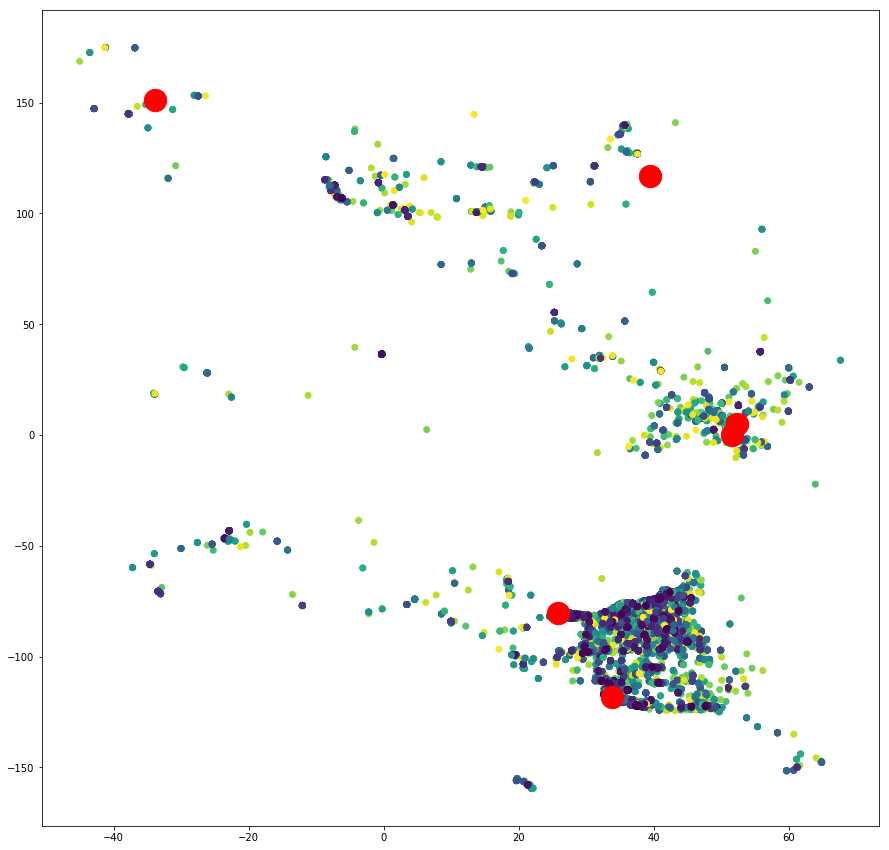

In [22]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(num=None, figsize=(15, 15))

x = df.values[:,0]
y = df.values[:,1]
colors = meanShift.labels_

plt.scatter(x, y, c=colors, alpha=1)

offices = np.array([[33.751277, -118.188740], [25.867736, -80.324116], [51.503016, -0.075479], [52.378894, 4.885084], [39.366487, 117.036146], [-33.868457, 151.205134]])

x = offices[:,0]
y = offices[:,1]
                   
plt.scatter(x, y, c="Red", s=500)
plt.show()

###  2.3 Filter clusters (2 балла): 
Как видим на графике, некоторые из получившихся кластеров содержат слишком мало точек — такие кластеры не интересны рекламодателям. Поэтому надо определить, какие из кластеров содержат, скажем, больше 15 элементов. Центры этих кластеров и являются оптимальными для размещения. 

**Выведите количество кластеров, которое удовлетворяет этому условию.**

**Hint**: `itertools.groupby`

###  Задание 2.4 (2 балла): 
Как мы помним, необходимо разместить только 20 баннеров близ офисов компании. Осталось определить 20 ближайших к ним центров кластеров. Т.е. посчитать дистанцию до ближайшего офиса для каждой точки и выбрать 20 с наименьшим значением.

**Выведите эти 20 центров кластеров, отсортрованных по возрастанию расстояния до ближайшего офиса.**

**Hint:** Для вычисления расстояния вы можете использовать обычную евклидову метрику и предполагать, что земля плоская. А можете использовать `geopy.distance.vincenty` если поймёте как.

Координата центра кластера ближайшего к какому-то из офисов компании должны быть `(52.37296399032261, 4.8923172225806466)`. Если у вас не так, то считайте, что вы сделали что-то неправильно. 